In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [0]:
#Convulutional Layer 1.
filter_size1 = 5        #Convolutional filters are 5 * 5 pixels.
num_filters1 = 16       #There are 16 of these filters.

#Convolutional Layer 2.
filter_size2 = 5        #Convolutional filters are 5 * 5 pixels.
num_filters2= 36        #There are 36 of these filters.

#Fully -connected layer.
fc_size = 128           # Number of neurons in fully-connected layer.

In [3]:
import os
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
  !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials
os.chdir(work_dir)

from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

fatal: destination path 'TensorFlow-Tutorials' already exists and is not an empty directory.


In [4]:
print("Size of :")
print("- Training -set:\t{}".format(data.num_train))
print("- Validation-set :\t{}".format(data.num_val))
print("-Test-set :\t\t{}".format(data.num_test))

Size of :
- Training -set:	55000
- Validation-set :	5000
-Test-set :		10000


In [5]:
#The number of pixels in each dimension of an image.
img_size =  data.img_size
print("img_size \t{}".format(img_size))

#The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat
print("img_size_flat :\t {}".format(img_size_flat))

#Tuple with heigth and width of images used t reshape arrays.
img_shape = data.img_shape
print("img_shape :\t {}".format(img_shape))

#Number of classes, one class for eahc of 10 digits.
num_classes = data.num_classes
print("num_classes : \t {}".format(num_classes))

#Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels
print("num_channels : \t{}".format(num_channels))

img_size 	28
img_size_flat :	 784
img_shape :	 (28, 28)
num_classes : 	 10
num_channels : 	1


In [0]:
def plot_images(images,cls_true,cls_pred = None):
    assert len(images) == len(cls_true) ==9
  
    #Create figure with 3 * 3 sub-plots.
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3,wspace = 0.3)
    
    for i,ax in enumerate(axes.flat):
        #Plot image 
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        #Show true and predicted classses
        if cls_pred is None :
            xlabel = "True :{0}".format(cls_true[i])
        else:
            xlabel = "True : {0},pred: {1}".format(cls_true[i],cls_pred[i])
            
        #Show the classes as the label on the x - axis.
        ax.set_xlabel(xlabel)
        
        #Removeticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    #Ensure the plot is shown correctky with multiple plots.
    # in a single Notebook cell.
    plt.show()

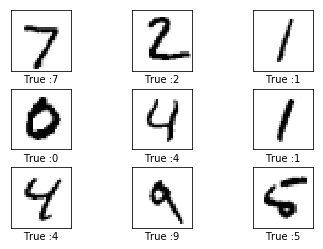

In [7]:
# Get the first images from the test-set
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images,cls_true = cls_true)

In [0]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))
  
def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

In [0]:
def new_conv_layer(input,
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling = True):
  
    shape = [filter_size,filter_size,num_input_channels,num_filters]
    
    weights = new_weights(shape = shape)
    
    biases = new_biases(length= num_filters)
    
    layer = tf.nn.conv2d(input = input,
                        filter = weights,
                        strides =[1,1,1,1],
                        padding ='SAME')
      
    layer += biases
    
    #Use pooling to downsampling the image resolution.
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding = 'SAME')
    layer = tf.nn.relu(layer)
    
    return layer,weights
    
    

In [0]:
#A convulational layer produces an output tensor of 4 dimension where as fully connected require input with two d variable.
def flatten_layer(layer):
    #Get the shape of input layer
    layer_shape = layer.get_shape()
    
    
    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer,[-1,num_features])
    
    return layer_flat,num_features

In [0]:
def  new_fc_layer(input,
                  num_inputs,
                    num_outputs,
                  use_relu = True ):

    weights = new_weights(shape = [num_inputs,num_outputs])
    biases = new_biases(length =num_outputs)    
    layer= tf.matmul(input,weights)+biases  
    if use_relu :
        layer = tf.nn.relu(layer)
    return layer

In [0]:
#placeholder varaiable
x= tf.placeholder(tf.float32,shape=[None,img_size_flat],name='x')

x_image = tf.reshape(x,[-1,img_size,img_size,num_channels])

y_true = tf.placeholder(tf.float32,shape=[None,num_classes],name = 'y_true')
y_true_cls = tf.argmax(y_true,axis = 1)

In [0]:
# Convolutional layer1
layer_conv1, weights_conv1 = \
                  new_conv_layer(input = x_image,
                                num_input_channels = num_channels,
                                filter_size=filter_size1,
                                num_filters = num_filters1,
                                use_pooling = True)

In [14]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [15]:
weights_conv1

<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>

In [0]:
# Convolutional layer2
layer_conv2,weights_conv2 = \
              new_conv_layer(input= layer_conv1,
                            num_input_channels = num_filters1,
                            filter_size = filter_size2,
                            num_filters = num_filters2, 
                            use_pooling = True)

In [17]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [18]:
weights_conv2

<tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>

In [19]:
layer_flat ,num_features = flatten_layer(layer_conv2)

layer_flat
num_features

1764

In [0]:
# Fully connected layer1
layer_fc1 = new_fc_layer(input = layer_flat,
                        num_inputs=num_features,
                        num_outputs = fc_size,
                        use_relu = True)

In [21]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [0]:
#second fully connected layer2
layer_fc2 = new_fc_layer(input = layer_fc1,
                         num_inputs = fc_size,
                        num_outputs = num_classes,
                        use_relu = True)

In [23]:
layer_fc2

<tf.Tensor 'Relu_3:0' shape=(?, 10) dtype=float32>

In [0]:
y_pred = tf.nn.softmax(layer_fc2)

y_pred_cls = tf.argmax(y_pred,axis =1 )

In [25]:
#cross_entropy is to be optimized and it consist of average loss of all images in a batch_size.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= layer_fc2,labels = y_true)

W0730 14:56:09.076933 140371470706560 deprecation.py:323] From <ipython-input-25-75c030ed10f1>:1: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
cost = tf.reduce_mean(cross_entropy)

In [0]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate= 1e-4).minimize(cost)

In [0]:
#performance measure
correct_prediction = tf.equal(y_pred_cls,y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [0]:
#Once the tensorflow graph has been created, we need to create a tensorflow session which is used to execute the graph.

In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [0]:
train_batch_size = 32

In [0]:
#Counter for total number of iteration performed  so far.
total_iterations =0
def optimize(num_iterations):
    #Ensure we update a global variable rather than a local copy.
    global total_iterations
    
    #start -time use dfor printing time-usage below.
    start_time = time.time()
    
    for i in range(total_iterations,
                  total_iterations + num_iterations):
        x_batch,y_true_batch , _  = data.random_batch(batch_size= train_batch_size)
        
        feed_dict_train = {x: x_batch,
                        y_true : y_true_batch}
      
        session.run(optimizer,feed_dict = feed_dict_train)
      
        if i % 100 ==0 :
            acc = session.run(accuracy,feed_dict=feed_dict_train)
        
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
        
            print(msg.format(i +1,acc))
    total_iterations += num_iterations
    
    end_time = time.time()
    
    time_dif = end_time - start_time
    
    print("Time usage: "+ str(timedelta(seconds=int(round(time_dif)))))

In [0]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = data.num_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.x_test[i:j, :]

        # Get the associated labels.
        labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    

In [0]:
for i in range(0,100):
  
  optimize(num_iterations=i)
  print("iterration number : \t{}".format(i))
  print_test_accuracy()

Time usage: 0:00:00
iterration number : 	0
Accuracy on Test-Set: 11.7% (1165 / 10000)
Optimization Iteration:      1, Training Accuracy:  12.5%
Time usage: 0:00:00
iterration number : 	1
Accuracy on Test-Set: 11.9% (1186 / 10000)
Time usage: 0:00:00
iterration number : 	2
Accuracy on Test-Set: 12.5% (1246 / 10000)
Time usage: 0:00:00
iterration number : 	3
Accuracy on Test-Set: 12.6% (1262 / 10000)
Time usage: 0:00:00
iterration number : 	4
Accuracy on Test-Set: 13.9% (1388 / 10000)
Time usage: 0:00:00
iterration number : 	5
Accuracy on Test-Set: 28.7% (2866 / 10000)
Time usage: 0:00:00
iterration number : 	6
Accuracy on Test-Set: 34.8% (3482 / 10000)
Time usage: 0:00:00
iterration number : 	7
Accuracy on Test-Set: 36.0% (3604 / 10000)
Time usage: 0:00:00
iterration number : 	8
Accuracy on Test-Set: 32.9% (3287 / 10000)
Time usage: 0:00:00
iterration number : 	9
Accuracy on Test-Set: 53.0% (5298 / 10000)
Time usage: 0:00:00
iterration number : 	10
Accuracy on Test-Set: 43.0% (4302 / 10